## Import libs

In [1]:
from math import sqrt, isnan
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.data import Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from util import metrics
from util.load_data import load_data
from util.evaluation import *

from madras_laftr.models import *
from madras_laftr.learning import *

## Preliminaries

In [2]:
batch_size = 64
epochs = 10
learning_rate = 0.001
opt = Adam(learning_rate=learning_rate)
CLAS_COEFF = 1.
FAIR_COEFF = 1.
RECON_COEFF = 0.
hidden_layer_specs = {'clas':[8] , 'enc':[8] , 'dec':[8] , 'adv':[8]}

## Load data

In [3]:
x_train, y_train, a_train = load_data('adult', 'train')
raw_data = (x_train, y_train, a_train)

In [4]:
xdim = x_train.shape[1]
ydim = y_train.shape[1]
adim = a_train.shape[1]
zdim = 8

In [5]:
train_data = Dataset.from_tensor_slices((x_train, y_train, a_train))
train_data = train_data.batch(batch_size, drop_remainder=True)
train_data

<BatchDataset shapes: ((64, 113), (64, 1), (64, 1)), types: (tf.float64, tf.float64, tf.float64)>

In [6]:
x_valid, y_valid, a_valid = load_data('adult', 'valid')

valid_data = Dataset.from_tensor_slices((x_valid, y_valid, a_valid))
valid_data = valid_data.batch(batch_size, drop_remainder=True)

In [7]:
x_test, y_test, a_test = load_data('adult', 'test')

test_data = Dataset.from_tensor_slices((x_test, y_test, a_test))
test_data = test_data.batch(batch_size, drop_remainder=True)

## Testing if models are being trained

### For DP

In [8]:
model = DemParGan(xdim, ydim, adim, zdim, hidden_layer_specs, recon_coeff=RECON_COEFF, clas_coeff=CLAS_COEFF, fair_coeff=FAIR_COEFF)

In [9]:
ret = train_loop(model, raw_data, train_data, 1, opt)

> Epoch | Model Loss | Class Loss | Adv Loss | Dec Loss | Class Acc | Adv Acc | Dec Acc
> 1 | -0.31123873591423035 | 1.3511191606521606 | 2.2848353385925293 | 62617.68359375 | 0.7524038461538461 | 0.6234665119363395 | -35.726458885941646


In [10]:
Y_hat, A_hat = validation(model, valid_data)
ret = compute_metrics(y_valid, Y_hat, a_valid, A_hat)

> Class Acc | Adv Acc
> 0.7850731382978724 | 0.636968085106383
> DP | DI | DEOPP
> 0.07270658016204834 | 0.01934388093650341 | 0.005795344710350037
> Confusion Matrix 
TN: 4270.0 | FP: 248.0 
FN: 1045.0 | TP: 453.0
> Confusion Matrix for A = 0 
TN: 1604.0 | FP: 63.0 
FN: 150.0 | TP: 62.0
> Confusion Matrix for A = 1 
TN: 2666.0 | FP: 185.0 
FN: 895.0 | TP: 391.0


### For EqOdds

In [11]:
model = EqOddsUnweightedGan(xdim, ydim, adim, zdim, hidden_layer_specs, recon_coeff=RECON_COEFF, clas_coeff=CLAS_COEFF, fair_coeff=FAIR_COEFF)

In [12]:
ret = train_loop(model, raw_data, train_data, 1, opt)

> Epoch | Model Loss | Class Loss | Adv Loss | Dec Loss | Class Acc | Adv Acc | Dec Acc
> 1 | 0.18813258409500122 | 1.3764359951019287 | 0.8120381832122803 | 61975.62890625 | 0.7814572281167109 | 0.6469247347480106 | 168.73238561007958


In [13]:
Y_hat, A_hat = validation(model, valid_data)
ret = compute_metrics(y_valid, Y_hat, a_valid, A_hat)

> Class Acc | Adv Acc
> 0.7942154255319149 | 0.706781914893617
> DP | DI | DEOPP
> 0.125355064868927 | 0.109934501349926 | 0.08655990660190582
> Confusion Matrix 
TN: 4195.0 | FP: 323.0 
FN: 915.0 | TP: 583.0
> Confusion Matrix for A = 0 
TN: 1597.0 | FP: 70.0 
FN: 161.0 | TP: 51.0
> Confusion Matrix for A = 1 
TN: 2598.0 | FP: 253.0 
FN: 754.0 | TP: 532.0


### For EqOpp

In [14]:
model = EqOppUnweightedGan(xdim, ydim, adim, zdim, hidden_layer_specs, recon_coeff=RECON_COEFF, clas_coeff=CLAS_COEFF, fair_coeff=FAIR_COEFF)

In [15]:
ret = train_loop(model, raw_data, train_data, 1, opt)

> Epoch | Model Loss | Class Loss | Adv Loss | Dec Loss | Class Acc | Adv Acc | Dec Acc
> 1 | -0.09690097719430923 | 1.991365671157837 | 2.335902690887451 | 61978.8359375 | 0.7642572944297082 | 0.5211787135278514 | -73.45610908488064


In [16]:
Y_hat, A_hat = validation(model, valid_data)
ret = compute_metrics(y_valid, Y_hat, a_valid, A_hat)

> Class Acc | Adv Acc
> 0.784906914893617 | 0.6329787234042553
> DP | DI | DEOPP
> 0.14201799035072327 | 0.13958758115768433 | 0.10034404695034027
> Confusion Matrix 
TN: 4259.0 | FP: 259.0 
FN: 1035.0 | TP: 463.0
> Confusion Matrix for A = 0 
TN: 1654.0 | FP: 13.0 
FN: 183.0 | TP: 29.0
> Confusion Matrix for A = 1 
TN: 2605.0 | FP: 246.0 
FN: 852.0 | TP: 434.0


## Models

In [17]:
cmap = sns.light_palette("seagreen", as_cmap=True)

In [18]:
#For DP
model = DemParGan(xdim, ydim, adim, zdim, hidden_layer_specs, recon_coeff=RECON_COEFF, clas_coeff=CLAS_COEFF, fair_coeff=FAIR_COEFF)
ret = train_loop(model, raw_data, train_data, epochs, opt)
Y_hat, A_hat = validation(model, valid_data)
ret4dp = compute_metrics(y_valid, Y_hat, a_valid, A_hat)

> Epoch | Model Loss | Class Loss | Adv Loss | Dec Loss | Class Acc | Adv Acc | Dec Acc
> 1 | -0.28857553005218506 | 1.41026771068573 | 2.275994300842285 | 62212.10546875 | 0.7664539124668435 | 0.5606763925729443 | -144.3355023209549
> 2 | -0.3010976016521454 | 1.3933517932891846 | 2.296644687652588 | 59206.93359375 | 0.7967092175066313 | 0.6174568965517242 | -50.81689323607427
> 3 | -0.3198963701725006 | 1.3839833736419678 | 2.343672513961792 | 59090.4609375 | 0.7965019893899205 | 0.6051475464190981 | -19.663793103448278
> 4 | -0.3120851218700409 | 1.3799301385879517 | 2.316185474395752 | 59272.8046875 | 0.7961289787798409 | 0.6092092175066313 | -24.21195291777188
> 5 | -0.5036833882331848 | 2.0133109092712402 | 3.5243611335754395 | 59378.5078125 | 0.786472148541114 | 0.505429376657825 | -43.69433852785146
> 6 | -0.1814921647310257 | 1.986957311630249 | 2.5314338207244873 | 59248.0546875 | 0.790948275862069 | 0.6900281830238727 | -44.26500331564987
> 7 | -0.2313227653503418 | 1.961765

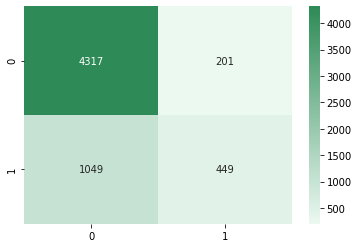

In [19]:
sns.heatmap(ret4dp[4], cmap=cmap, annot=True, fmt='g')

In [20]:
#For EQODDS
model = EqOddsUnweightedGan(xdim, ydim, adim, zdim, hidden_layer_specs, recon_coeff=RECON_COEFF, clas_coeff=CLAS_COEFF, fair_coeff=FAIR_COEFF)
ret = train_loop(model, raw_data, train_data, epochs, opt)
Y_hat, A_hat = validation(model, valid_data)
ret4eqodds = compute_metrics(y_valid, Y_hat, a_valid, A_hat)

> Epoch | Model Loss | Class Loss | Adv Loss | Dec Loss | Class Acc | Adv Acc | Dec Acc
> 1 | -0.3804892599582672 | 1.4572467803955078 | 2.598714590072632 | 58020.5859375 | 0.7662052387267905 | 0.6924320291777188 | 102.40227122015915
> 2 | -0.3292939364910126 | 1.425542950630188 | 2.4134247303009033 | 58006.53125 | 0.7932692307692308 | 0.8266744031830239 | 86.31556697612731
> 3 | -0.31148532032966614 | 1.4061293601989746 | 2.340585231781006 | 58020.21875 | 0.7988229442970822 | 0.8978779840848806 | 64.46046087533156
> 4 | -0.3083977997303009 | 1.4030791521072388 | 2.328272581100464 | 58008.66015625 | 0.800895225464191 | 0.8984996684350133 | 69.03527022546419
> 5 | -0.30785077810287476 | 1.4004132747650146 | 2.323965549468994 | 58017.32421875 | 0.8010610079575597 | 0.8982509946949602 | 70.89845822281167
> 6 | -0.3098289668560028 | 1.3978103399276733 | 2.3272972106933594 | 58004.3671875 | 0.8020142572944298 | 0.8972148541114058 | 74.38739224137932
> 7 | -0.30795860290527344 | 1.3956086635

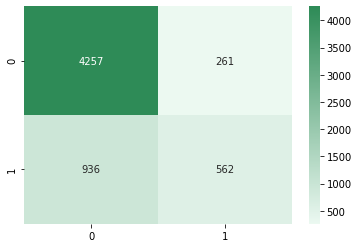

In [21]:
sns.heatmap(ret4eqodds[4], cmap=cmap, annot=True, fmt='g')

In [22]:
#For EQOPP
model = EqOddsUnweightedGan(xdim, ydim, adim, zdim, hidden_layer_specs, recon_coeff=RECON_COEFF, clas_coeff=CLAS_COEFF, fair_coeff=FAIR_COEFF)
ret = train_loop(model, raw_data, train_data, epochs, opt)
Y_hat, A_hat = validation(model, valid_data)
ret4eqopp = compute_metrics(y_valid, Y_hat, a_valid, A_hat)

> Epoch | Model Loss | Class Loss | Adv Loss | Dec Loss | Class Acc | Adv Acc | Dec Acc
> 1 | -0.26677462458610535 | 1.8717681169509888 | 2.6720919609069824 | 70541.4296875 | 0.7658322281167109 | 0.6645805702917772 | -380.24486074270555
> 2 | -0.07778513431549072 | 1.697279691696167 | 1.9306350946426392 | 61172.3125 | 0.8127486737400531 | 0.8304459549071618 | -359.39273872679047
> 3 | -0.032360196113586426 | 1.7287510633468628 | 1.825831651687622 | 59264.76171875 | 0.8180122679045093 | 0.9066644562334217 | -139.99987566312998
> 4 | -0.016210198402404785 | 1.7341628074645996 | 1.782793402671814 | 59108.07421875 | 0.8180537135278515 | 0.90529675066313 | -12.127693965517242
> 5 | 0.44666385650634766 | 1.7862308025360107 | 0.4462391138076782 | 60175.3515625 | 0.8187582891246684 | 0.9586787135278515 | 1.2508703580901857
> 6 | 0.44240662455558777 | 1.7675281763076782 | 0.4403083920478821 | 60175.70703125 | 0.8190484084880636 | 0.9702834880636605 | -2.6983173076923075
> 7 | 0.4425748288631439

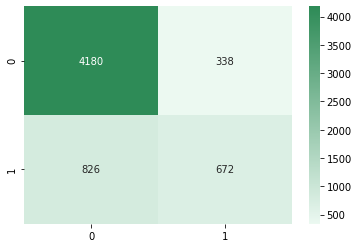

In [23]:
sns.heatmap(ret4eqopp[4], cmap=cmap, annot=True, fmt='g')

In [24]:
sns.set_style('darkgrid')

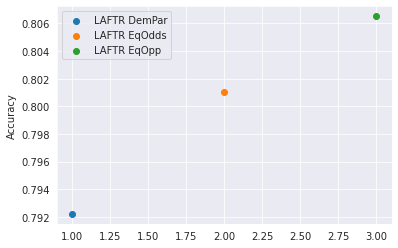

In [25]:
'''plt.plot()
plt.ylabel('Accuracy')

# plotting the line 1 points 
# plt.plot(fair_coeff_list, laftr_accs, label = "laftr")
# line 2 points

# plotting the line 2 points 
plt.plot(fair_coeff_list, unfair_accs4dp, label = "LAFTR DP")
plt.plot(fair_coeff_list, unfair_accs4di, '--', label = "LAFTR EODD")
plt.plot(fair_coeff_list, unfair_accs4deopp, ':', label = "LAFTR EOPP")
plt.xlabel('Fair coefficient')
plt.legend()
plt.show()'''

y=[2,4,6]
sns.set_style('darkgrid')
plt.ylabel('Accuracy')

plt.scatter(1, ret4dp[0], label = "LAFTR DemPar")

plt.scatter(2, ret4eqodds[0], label = "LAFTR EqOdds")

plt.scatter(3, ret4eqopp[0], label = "LAFTR EqOpp")

#plt.xlabel('Fair coefficient')
plt.legend()

plt.show()

In [26]:
'''plt.plot()
plt.ylabel('\u0394DP')

# plotting the line 1 points 
#plt.plot(fair_coeff_list, laftr_dps, label = "laftr")
# line 2 points

# plotting the line 2 points 
plt.plot(fair_coeff_list, unfair_dps4dp, label = "LAFTR DP")
plt.plot(fair_coeff_list, unfair_dps4di, '--', label = "LAFTR EODD")
plt.plot(fair_coeff_list, unfair_dps4deopp, ':', label = "LAFTR EOPP")

plt.xlabel('Fair coefficient')
plt.legend()
plt.show()'''

'plt.plot()\nplt.ylabel(\'ΔDP\')\n\n# plotting the line 1 points \n#plt.plot(fair_coeff_list, laftr_dps, label = "laftr")\n# line 2 points\n\n# plotting the line 2 points \nplt.plot(fair_coeff_list, unfair_dps4dp, label = "LAFTR DP")\nplt.plot(fair_coeff_list, unfair_dps4di, \'--\', label = "LAFTR EODD")\nplt.plot(fair_coeff_list, unfair_dps4deopp, \':\', label = "LAFTR EOPP")\n\nplt.xlabel(\'Fair coefficient\')\nplt.legend()\nplt.show()'

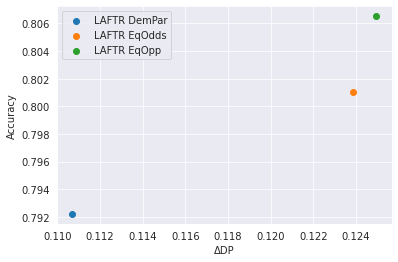

In [27]:
'''plt.plot()
plt.ylabel('Accuracy')

# plotting the line 1 points 
# plt.plot(laftr_dps, laftr_accs, label = "laftr")
# line 2 points

# plotting the line 2 points 
plt.plot(sorted_unfair_dps4dp, sorted_unfair_accs_dps4dp, label = "LAFTR DP")
plt.plot(sorted_unfair_dps4di, sorted_unfair_accs_dps4di, '--', label = "LAFTR EODD")
plt.plot(sorted_unfair_dps4deopp, sorted_unfair_accs_dps4deopp, '--', label = "LAFTR EOPP")

plt.xlabel('\u0394DP')
plt.legend()
plt.show()'''

plt.plot()
plt.ylabel('Accuracy')

plt.scatter(ret4dp[1], ret4dp[0], label = "LAFTR DemPar")

plt.scatter(ret4eqodds[1], ret4eqodds[0], label = "LAFTR EqOdds")

plt.scatter(ret4eqopp[1], ret4eqopp[0], label = "LAFTR EqOpp")

plt.xlabel('\u0394DP')
plt.legend()
plt.show()

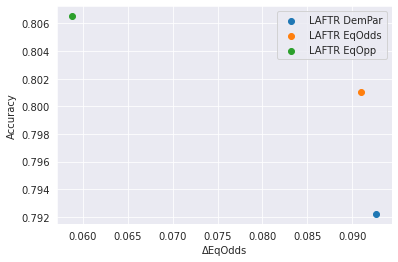

In [28]:
'''plt.plot()
plt.ylabel('Accuracy')

# plotting the line 1 points 
# plt.plot(laftr_dps, laftr_accs, label = "laftr")
# line 2 points

# plotting the line 2 points 
plt.plot(sorted_unfair_dis4dp, sorted_unfair_accs_dis4dp, '--', label = "LAFTR DP")
plt.plot(sorted_unfair_dis4di, sorted_unfair_accs_dis4di, label = "LAFTR EODD")
plt.plot(sorted_unfair_dis4deopp, sorted_unfair_accs_dis4deopp, '--', label = "LAFTR EOPP")

plt.xlabel('\u0394EOdds')
plt.legend()
plt.show()'''

plt.plot()
plt.ylabel('Accuracy')

plt.scatter(ret4dp[2], ret4dp[0], label = "LAFTR DemPar")

plt.scatter(ret4eqodds[2], ret4eqodds[0], label = "LAFTR EqOdds")

plt.scatter(ret4eqopp[2], ret4eqopp[0], label = "LAFTR EqOpp")

plt.xlabel('\u0394EqOdds')
plt.legend()
plt.show()

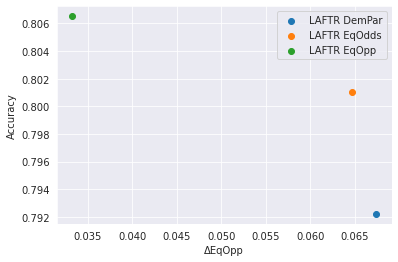

In [29]:
'''plt.plot()
plt.ylabel('Accuracy')

# plotting the line 1 points 
plt.plot(laftr_dps, laftr_accs, label = "laftr")
# line 2 points#

# plotting the line 2 points 
plt.plot(sorted_unfair_deopps4dp, sorted_unfair_accs_eopps4dp, '--', label = "LAFTR DP")
plt.plot(sorted_unfair_deopps4di, sorted_unfair_accs_eopps4di, '--', label = "LAFTR EODD")
plt.plot(sorted_unfair_deopps4deopp, sorted_unfair_accs_eopps4deopp, label = "LAFTR EOPP")

plt.xlabel('\u0394EOpp')
plt.legend()
plt.show()'''

plt.plot()
plt.ylabel('Accuracy')

plt.scatter(ret4dp[3], ret4dp[0], label = "LAFTR DemPar")

plt.scatter(ret4eqodds[3], ret4eqodds[0], label = "LAFTR EqOdds")

plt.scatter(ret4eqopp[3], ret4eqopp[0], label = "LAFTR EqOpp")

plt.xlabel('\u0394EqOpp')
plt.legend()
plt.show()